In [124]:
import os
import numpy as np
from rdkit import Chem
from rdkit.Chem.rdchem import BondType
from rdkit.Chem.rdmolfiles import MolFromMol2File
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

In [125]:
# Define the atom types we are interested in for the protein
atomDict = {'C': np.int8(1), 'O': np.int8(2), 'N': np.int8(3), 'S': np.int8(4), 'P': np.int8(5), 'H': np.int8(6), 'X': np.int8(7)}
rAtomDict = {v: k for (k,v) in atomDict.items()}
rAtomDict[np.int8(0)] = None

# Define atom types and bond orders we are interested in for the ligand
# We encode aromatics as a separate bond type (1.5: np.int8(4))
bondType = {0.0: np.int8(0), 1.0: np.int8(1), 2.0: np.int8(2), 3.0: np.int8(3), 1.5: np.int8(4)}
bondMap = np.vectorize(lambda x: bondType[x])
# The None entry in ligAtom is necessary to ensure correct one-hot encoding
ligAtom = {None: 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4, 'S': 5, 'X': 6}
ligAtomMap = np.vectorize(lambda x: ligAtom[x.GetSymbol()] if x.GetSymbol() in ligAtom else 6)

In [601]:
import torch
from torch.utils.data import Dataset, DataLoader
class PDBbindPLDataset(Dataset):
    """PDBbind v2020 protein-ligand dataset."""

    def __init__(self, root_dir, n_points=8000, lig_size=32, train=True, transform=None):
        """
        Args:
            root_dir (string): Directory with all the protein-ligand complexes.
            n_points (int): Number of protein atoms to be extracted.
            lig_size (int): Maximum number of atoms to be kept in ligands.
            train (boolean): Splitting for train or test set.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.n_points = n_points
        self.lig_size = lig_size
        self.split = 'train' if train else 'test'
        self.pids = self._read_pids()
        # All p-l complexes with heavy atoms orther than below are filtered out.
        self.atom_encoder = {None: 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4, 'S':5, 'Cl': 6}
        self.transform = transform

    def _read_pids(self):
        with open(os.path.join(self.root_dir, f'index/{self.split}.txt'), 'r') as f:
            pids = f.read().splitlines()
        return pids

    def __len__(self):
        return len(self.pids)

    def __getitem__(self, idx):
        pid = self.pids[idx]
        with open(os.path.join(self.root_dir, f'{pid}/{pid}_protein.pdb')) as f:
            # Read 3D coordinates of protein atoms in angstroms.
            protein = [[float(i) for i in (line[29:38], line[38:46], line[46:54])]+[self.atom_encoder[line.split()[2][0]]] \
                            for line in f.read().split('\n') if line[:4]=='ATOM' and line.split()[2][0]!='H' and not line.split()[2][0].isdigit()]
        # Load ligand from .mol2 file.
        ligand = MolFromMol2File(os.path.join(self.root_dir, f'{pid}/{pid}_ligand.mol2'))

        # Calculate ligand centroid and rank protein points by distance.
        l_centroid = np.mean(ligand.GetConformer().GetPositions(), 0)
        protein = np.asarray(sorted(protein, key=lambda x: np.linalg.norm(x[:-1] - l_centroid)))
        
        # Pad null points or select self.n_points atoms closest to l_centriod.
        if protein.shape[0] > self.n_points:
            protein = protein[:self.n_points]
        else:
            pad = np.repeat([[0, 0, 0, 0]], self.n_points - protein.shape[0], axis=0)
            protein = np.concatenate((protein, pad), 0)

        atoms = [self.atom_encoder[i.GetSymbol()] for i in list(ligand.GetAtoms())]
        bonds = GetAdjacencyMatrix(ligand, useBO=True)
        if len(atoms) > self.lig_size:
            indices = np.argpartition(np.sum(bonds, axis=0), len(atoms)-self.lig_size) # rank atoms by bond orders
            indices = sorted(indices[:len(atoms)-self.lig_size], reverse=True) # indices to be removed

            for i in indices:
                bonds = np.concatenate((bonds[:i,:], bonds[i+1:,:]), axis=0)
                bonds = np.concatenate((bonds[:,:i], bonds[:,i+1:]), axis=1)
                atoms = np.concatenate((atoms[:i], atoms[i+1:]))
        else:
            bonds = np.pad(bonds, (0, self.lig_size-len(atoms)))
            atoms = np.pad(atoms, (0, self.lig_size-len(atoms)))
            
        return protein, (atoms, bonds)
self = PDBbindPLDataset('data/pdbbind/refined-set', train=True)

In [607]:
protein, ligand = self[1]

In [608]:
ligand[0]

array([1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 3, 1, 1, 2, 1, 1,
       2, 1, 3, 1, 1, 1, 5, 1, 6, 1])

In [606]:
ligand[1]

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

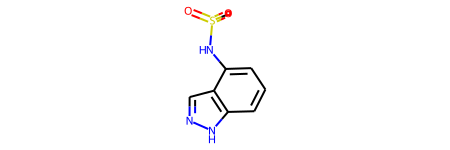

In [544]:
ligand

In [581]:
adj.tolist()

[[0.0, 1.5, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0],
 [1.5, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0],
 [1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5],
 [0.0, 1.5, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.5, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [1.5, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5],
 [0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [445]:
l_centroid

array([ 13.23878571, -17.77564286, -20.20235714])

In [428]:
max_point

32627

In [410]:
np.mean(protein, 0)

array([ 19.97096484, -13.11397237, -12.34311386])

In [406]:
ligand.GetConformer().GetPositions()

array([[ 12.85 , -18.83 , -20.081],
       [ 13.612, -19.985, -19.693],
       [ 11.526, -19.177, -20.024],
       [ 15.042, -19.948, -19.687],
       [ 15.644, -18.765, -20.063],
       [ 14.873, -17.604, -20.454],
       [ 13.629, -14.619, -21.769],
       [ 12.766, -15.015, -20.717],
       [ 11.449, -14.487, -20.642],
       [ 13.574, -14.699, -19.26 ],
       [ 12.622, -16.614, -20.925],
       [ 13.493, -17.648, -20.466],
       [ 12.741, -21.004, -19.41 ],
       [ 11.522, -20.464, -19.642]])

In [375]:
import numpy as np
train_dir = 'data/pdbbind/refined-set/index/train.txt'
test_dir = 'data/pdbbind/refined-set/index/test.txt'
for i in good_pids:
    if np.random.rand() < 0.85:
        with open(train_dir, 'a') as f:
            f.writelines(i + '\n')
    else:
        with open(test_dir, 'a') as f:
            f.writelines(i + '\n')

In [ ]:
set_name = 'general'
pl_dir = f'data/pdbbind/{set_name}-set'
atom_set = set([])
for  PDBID in os.listdir(pl_dir):
    # Load the protein by parsing the .pdb file
    if PDBID in ('readme', 'index'):
        continue
    with open(f'data/pdbbind/{set_name}-set/{PDBID}/{PDBID}_protein.pdb') as f:
        data = [(line.split()[2][0], [float(i) for i in (line[31:38], line[38:46], line[46:54])]) \
                        for line in f.read().split('\n') if line[:4]=='ATOM' and line.split()[2][0]!='H' and not line.split()[2][0].isdigit()]
        for i in data:
            if i[0] not in atom_set:
                print(PDBID, i)
                atom_set.add(i[0])

1hy7 ('N', [-5.679, 59.242, 63.697])
1hy7 ('C', [-6.177, 58.241, 62.701])
1hy7 ('O', [-7.473, 59.955, 61.608])
1hy7 ('S', [-12.888, 35.541, 48.504])


In [201]:
from rdkit.Chem.rdmolfiles import MolFromMol2File
from rdkit.Chem.rdmolops import GetAdjacencyMatrix, RemoveHs

PDBID = '1a94'
with open(f'data/pdbbind/refined-set/{PDBID}/{PDBID}_protein.pdb') as f:
    # The 77th character is the atom type, while the 30th through 53 characters are the 3D coordinates in angstroms
    protein = [(i[77], np.array([float(k) for k in (i[30:38],i[38:46], i[46:54])])) \
                    for i in f.read().split('\n') if i[:4] == 'ATOM']

imageSize, resolution = 10, 2
ligand = MolFromMol2File(f'data/pdbbind/refined-set/{PDBID}/{PDBID}_ligand.mol2')
# rdkit is unable to process some percentage of structures
# remove explicit hydrogens
ligand = RemoveHs(ligand)
centroid = np.mean(ligand.GetConformer().GetPositions(), axis=0)
# Calculate the lower bound on atom coordinates that will end up in the protein image
lower = centroid - np.repeat(imageSize // 2 * resolution, 3)
# Translate the protein so that the lower bound corresponds to grid index [0,0,0]
protein = [(i[0], i[-1]-lower) for i in protein]
# Convert 3D coordinates to grid indices
protein = [(i, (j // resolution).astype(np.int8)) for (i,j) in protein]
# Filter atoms which are within the imageSize x imageSize x imageSize box
protein = [i for i in protein if np.all(i[1] >= 0) and np.all(i[1] < imageSize)]
protImage = np.zeros((imageSize, imageSize, imageSize, len(atomDict)+1), dtype=bool)
protImage[:, :, :, 0] = True
for (i,j) in protein:
    protImage[j[0], j[1], j[2], :] = [k == atomDict[i] for k in range(len(atomDict)+1)]
# Get the ligand adjacency matrix with bond orders
adj = GetAdjacencyMatrix(ligand, useBO=True)
# Now remove atoms with lowest bond order until a maximum of 36 atoms remain
toRemove = []
while adj.shape[0] > 36:
    # Get the bond orders of each atom
    sums = np.sum(adj, axis=0)
    # Find a minimum bond order atom
    i = np.argmin(sums)
    # Remove that atom from the adjacency matrix
    adj = np.concatenate((adj[:i,:], adj[i+1:,:]), axis=0)
    adj = np.concatenate((adj[:,:i], adj[:,i+1:]), axis=1)
    # Keep track of which atoms have been removed from the adjacency matrix
    toRemove.append(i)
# Standardize the adjacency matrices to a 36x36 matrix
if adj.shape[0] < 36:
    result = np.zeros((36, 36))
    result[:len(adj), :len(adj)] = adj
    adj = result

# Convert bond orders to categories
bonds = bondMap(adj)
# One-hot encode adjacency matrix
bonds = np.array([[[j == t for t in range(len(bondType))] for j in i] for i in bonds])
# Process the atom types
atomList = list(ligAtomMap(ligand.GetAtoms()))
# Remove atoms in the same order they were removed from the adjacency matrix
for i in toRemove:
    del atomList[i]
# Standardize to 36 atoms
atoms = np.zeros(36)
atoms[:len(atomList)] = atomList
# One-hot encode atom types
atoms = np.array([[i == t for t in range(len(ligAtom))] for i in atoms])

In [378]:
len(wrong_pids)+4649

5316

In [365]:
pids = [pid for pid in os.listdir('data/pdbbind/refined-set') if pid not in ('index', 'readme')]
# PDBID = '5nxi'
atms = set([])
wrong_pids = []
unavail_pids = []
good_pids = []
for PDBID in pids:
    ligand = MolFromMol2File(f'data/pdbbind/refined-set/{PDBID}/{PDBID}_ligand.mol2')
    if ligand is None:
        wrong_pids.append(PDBID)
        continue
    for i in [i.GetSymbol() for i in list(ligand.GetAtoms())]:
        if i not in ['C', 'F', 'N', 'O', 'S', 'Cl']:
            unavail_pids.append(PDBID)
            break
    good_pids.append(PDBID)
    atms = atms.union(set([i.GetSymbol() for i in list(ligand.GetAtoms())]))

[00:27:25] 5ahw_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27:25] 5u8c_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27:25] 4pvx_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27:25] 1gvw_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27:25] 6mnv_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27:25] 3fzy_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27:25] 4u73_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27:25] 3q7q_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27:25] 1a1e_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27:25] 1d09_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27:25] 2gsu_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27:25] 3a1c_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27:25] 4d3h_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27:25] 2vt3_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[00:27

In [371]:
len(good_pids)

4649

In [302]:
PDBID = '1a1c'
filename = f'data/pdbbind/general-set/{PDBID}_ligand.sdf'
suppl = Chem.SDMolSupplier(filename)[0]

OSError: File error: Bad input file data/pdbbind/general-set/1a1c_ligand.sdf

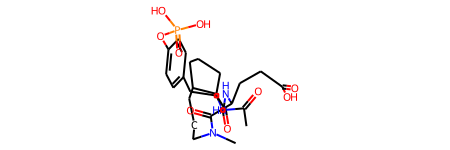

In [296]:
suppl

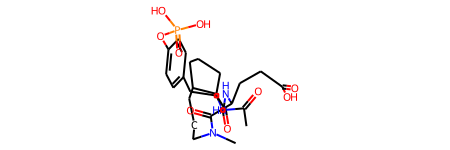

In [290]:
list(filter(lambda x: x is not None, Chem.SDMolSupplier(filename)))[0]

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [ ]:
landmarks_frame = pd.read_csv('data/faces/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


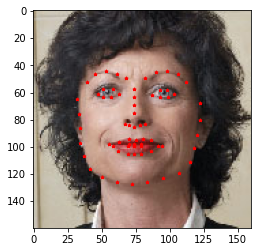

In [ ]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='*', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/faces/', img_name)),
               landmarks)
plt.show()

In [ ]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample


data/faces/faces/0805personali01.jpg
0 (324, 215, 3) (68, 2)


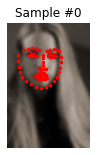

data/faces/faces/1084239450_e76e00b7e7.jpg
1 (500, 333, 3) (68, 2)


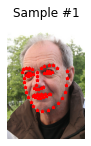

data/faces/faces/10comm-decarlo.jpg
2 (250, 258, 3) (68, 2)


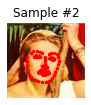

data/faces/faces/110276240_bec305da91.jpg
3 (434, 290, 3) (68, 2)


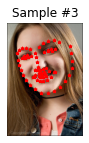

In [ ]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/faces/face_landmarks.csv',
                                    root_dir='data/faces/faces')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}


data/faces/faces/person-7.jpg


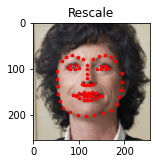

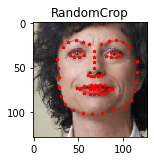

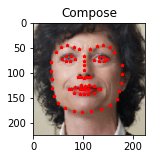

In [ ]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()


In [ ]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/faces/face_landmarks.csv',
                                           root_dir='data/faces/faces',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

data/faces/faces/0805personali01.jpg
0 torch.Size([3, 224, 224]) torch.Size([68, 2])
data/faces/faces/1084239450_e76e00b7e7.jpg
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
data/faces/faces/10comm-decarlo.jpg
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
data/faces/faces/110276240_bec305da91.jpg
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


data/faces/faces/363149951_8be04dc6c0.jpg
data/faces/faces/2370961440_6bc8ce346c.jpg
data/faces/faces/2328398005_d328a70b4c.jpg
data/faces/faces/92053278_be61a225d2.jpg
data/faces/faces/matt-mathes.jpgdata/faces/faces/3298715079_5af7c78fcb.jpg

data/faces/faces/297448785_b2dda4b2c0.jpg
data/faces/faces/1383023626_8a49e4879a.jpg
data/faces/faces/252418361_440b75751b.jpg
data/faces/faces/person_TjahjonoDGondhowiardjo.jpg
data/faces/faces/3555944509_7b477069c6.jpg
data/faces/faces/3638950581_3387685d3a.jpg
data/faces/faces/2173711035_dbd53b4f9f.jpg
data/faces/faces/3362762930_24f76cb89c.jpg
data/faces/faces/3074791551_baee7fa0c1.jpg
data/faces/faces/3646828311_bfeb429ef7.jpgdata/faces/faces/96063776_bdb3617b64.jpg

data/faces/faces/personalpic.jpg
data/faces/faces/2322901504_08122b01ba.jpg
data/faces/faces/303808204_1f744bc407.jpg
data/faces/faces/2956581526_cd803f2daa.jpg
data/faces/faces/3461016494_56cce9c984.jpg
data/faces/faces/1878519279_f905d4f34e.jpg
data/faces/faces/2711409561_a07

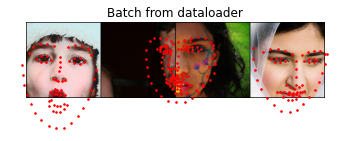

data/faces/faces/3574737496_6ee8207045.jpg
data/faces/faces/2647088981_60e9fe40cd.jpg
data/faces/faces/1198_0_861.jpg
data/faces/faces/110276240_bec305da91.jpg


In [ ]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
